In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models, metrics
import numpy as np
import tensorflow as tf


2022-08-15 19:25:38.972336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 19:25:38.972403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Create list of all targets (minus background noise)
dataset_path = '/home/anass/Projet_Stage/Database-20220727T140818Z-001/organized/normalized1'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')

In [3]:
# Settings
feature_sets_path = '/home/anass/Projet_Stage/Database-20220727T140818Z-001/'
feature_sets_filename = 'port_npz.npz'
wake_words = all_targets
joined_wake_words = '_'.join(wake_words)
model_filename = f'wake_words_{joined_wake_words}_model_100_percent.h5'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
# Peek at labels
print(y_val)

(916, 16, 16)
(113, 16, 16)
(115, 16, 16)
[0. 0. 1. 4. 7. 4. 7. 2. 0. 3. 7. 7. 0. 1. 4. 2. 1. 1. 7. 0. 5. 1. 4. 3.
 7. 7. 7. 6. 6. 6. 3. 5. 4. 3. 3. 1. 4. 3. 1. 1. 3. 0. 4. 6. 2. 3. 4. 3.
 2. 2. 2. 2. 1. 5. 2. 0. 4. 6. 4. 7. 3. 5. 5. 6. 1. 0. 1. 3. 7. 1. 6. 1.
 3. 7. 2. 7. 5. 4. 0. 2. 5. 6. 2. 0. 6. 1. 0. 5. 1. 0. 7. 7. 6. 1. 1. 0.
 1. 1. 5. 6. 5. 0. 0. 1. 3. 3. 3. 4. 0. 2. 4. 6. 1.]


In [7]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_words_indexes = [all_targets.index(wake_word) for wake_word in wake_words]
ys_train = np.array(list(map(np.array, zip(*[np.equal(y_train, wake_word_index).astype('float64') for wake_word_index in wake_words_indexes]))))
ys_val = np.array(list(map(np.array, zip(*[np.equal(y_val, wake_word_index).astype('float64') for wake_word_index in wake_words_indexes]))))
ys_test = np.array(list(map(np.array, zip(*[np.equal(y_test, wake_word_index).astype('float64') for wake_word_index in wake_words_indexes]))))

In [8]:
# What percentage of 'stop' appear in validation labels
print(tuple(sum(y_val) / len(y_val) for y_val in zip(*ys_val)))

(0.1415929203539823, 0.18584070796460178, 0.10619469026548672, 0.13274336283185842, 0.11504424778761062, 0.08849557522123894, 0.10619469026548672, 0.12389380530973451)


In [9]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0],
                          x_train.shape[1],
                          x_train.shape[2],
                          1)
x_val = x_val.reshape(x_val.shape[0],
                      x_val.shape[1],
                      x_val.shape[2],
                      1)
x_test = x_test.reshape(x_test.shape[0],
                        x_test.shape[1],
                        x_test.shape[2],
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(916, 16, 16, 1)
(113, 16, 16, 1)
(115, 16, 16, 1)
(16, 16, 1)


In [10]:
# Build model
model = models.Sequential()
model.add(layers.Conv2D(64, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(wake_words), activation='sigmoid'))

2022-08-15 19:26:00.254142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 19:26:00.255857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 19:26:00.256208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-15 19:26:00.256487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-15 19:26:00.256757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [11]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

In [12]:
# Add training parameters to model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              loss_weights=[1, 100],
              metrics=['acc', metrics.Precision(), metrics.Recall()])

In [13]:
# Train
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x_train,
                    ys_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(x_val, ys_val),
                    callbacks=[callback],)

Epoch 1/100
10/10 [==============================] - 2s 67ms/step - loss: 0.5179 - acc: 0.1517 - precision: 0.1475 - recall: 0.1648 - val_loss: 0.3800 - val_acc: 0.2655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.4339 - acc: 0.1266 - precision: 0.1633 - recall: 0.0262 - val_loss: 0.3753 - val_acc: 0.2301 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 0.4143 - acc: 0.1168 - precision: 0.1600 - recall: 0.0087 - val_loss: 0.3720 - val_acc: 0.2655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 0.3994 - acc: 0.1790 - precision: 0.4286 - recall: 0.0098 - val_loss: 0.3715 - val_acc: 0.2920 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 0.3957 - acc: 0.1747 - precision: 0.35

Epoch 39/100
10/10 [==============================] - 0s 23ms/step - loss: 0.1071 - acc: 0.8581 - precision: 0.8864 - recall: 0.7926 - val_loss: 0.1251 - val_acc: 0.7699 - val_precision: 0.8218 - val_recall: 0.7345
Epoch 40/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0985 - acc: 0.8559 - precision: 0.8794 - recall: 0.7882 - val_loss: 0.1301 - val_acc: 0.7965 - val_precision: 0.8148 - val_recall: 0.7788
Epoch 41/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0937 - acc: 0.8657 - precision: 0.8869 - recall: 0.8133 - val_loss: 0.1156 - val_acc: 0.7965 - val_precision: 0.8302 - val_recall: 0.7788
Epoch 42/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0833 - acc: 0.8865 - precision: 0.9088 - recall: 0.8373 - val_loss: 0.1116 - val_acc: 0.8142 - val_precision: 0.8349 - val_recall: 0.8053
Epoch 43/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0819 - acc: 0.8941 - precision: 0.9048 - recall: 0.8406 - val_l

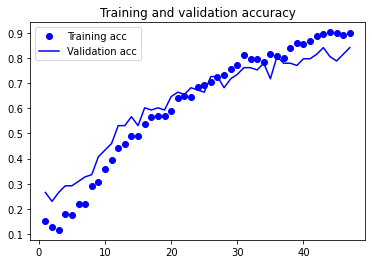

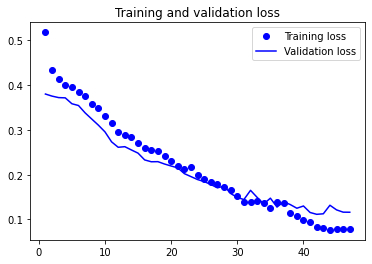

NameError: name 'precision' is not defined

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot results
import matplotlib.pyplot as plt

 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

 


epochs = range(1, len(acc) + 1)

 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

 

plt.figure()

 

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

 
plt.savefig('Training and validation loss.png')
plt.show()

 


plt.figure()

 

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

 
plt.savefig('Training and validation precision.png')

plt.show()

 

plt.figure()

 

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

 

plt.show()

In [15]:
# Save the model as a file
models.save_model(model, model_filename)

# See which are 'stop'
#for idx, y in enumerate(y_test):
#    if y == 1:
#        print(idx)

# TEST: Load model and run it against test set
#model = models.load_model(model_filename)
#for i in range(100, 200):
#    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

# Evaluate model with test set
model.evaluate(x=x_test, y=ys_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.1446 - acc: 0.7652 - precision: 0.8384 - recall: 0.7217


[0.14457839727401733,
 0.7652173638343811,
 0.8383838534355164,
 0.7217391133308411]

29/29 [==============================] - 0s 4ms/step
(916, 8)


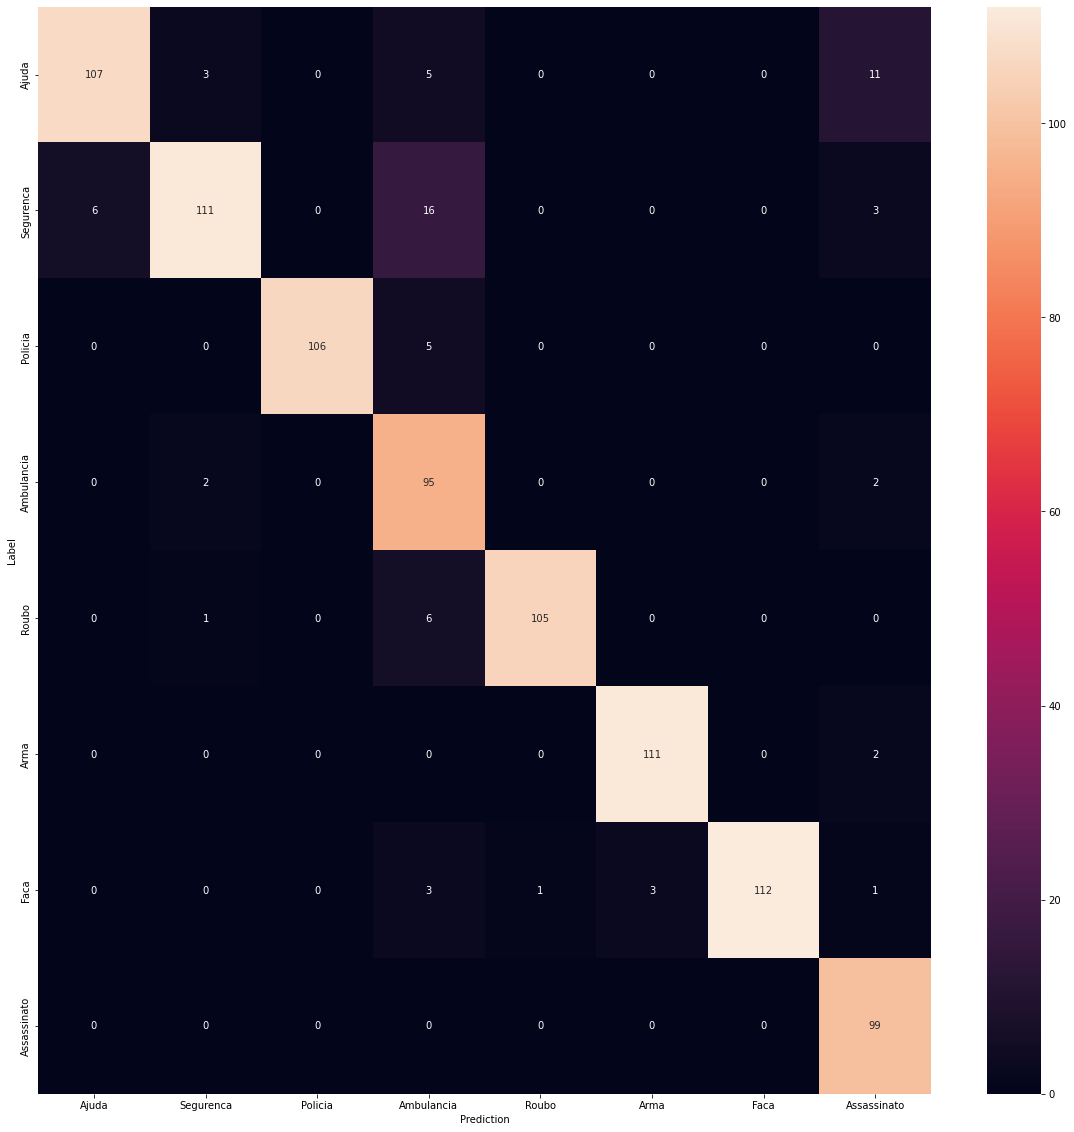

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred=model.predict(x_train)
print(y_pred.shape)
confusion_mtx = tf.math.confusion_matrix(y_pred.argmax(axis=1),ys_train.argmax(axis=1))
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mtx,
            xticklabels=wake_words,
            yticklabels=wake_words,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [18]:
all_targets

['Ajuda',
 'Segurenca',
 'Policia',
 'Ambulancia',
 'Roubo',
 'Arma',
 'Faca',
 'Assassinato']